<h2 align="center"> Лабораторна робота №5</h2>
<h3 align="center">Візуалізація даних</h3>
<p align="center">ФБ-23 Ткачук Андрій</p>

<b>Мета роботи:</b> отримати поглиблені навички з візуалізації даних; ознайомитись з matplotlib.widgets, scipy.signal.filters, а також з Plotly, Bokeh, Altair; отримати навички зі створення інтерактивних застосунків для швидкого підбору параметрів і аналізу отриманих результатів

Встановити ipympl

In [1]:
%matplotlib widget

## Завдання 1+2+власний фільтр


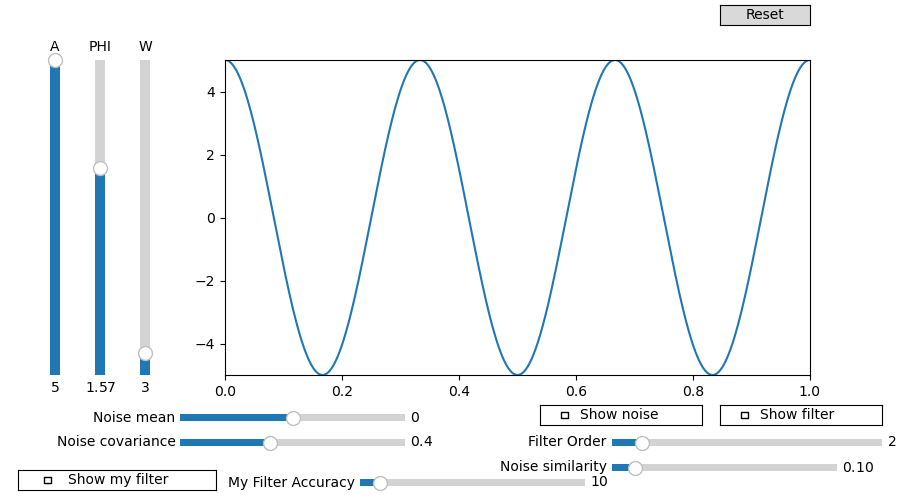

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider,Button,CheckButtons
import scipy


def func(a,w,t,phi):
    return a * np.sin(2*np.pi*w*t+phi)


#Початкові дані
t=np.linspace(0,1,1000)
a=5
w=3
phi=np.pi/2

#Створення фігури та графіку
fig,ax=plt.subplots(figsize=(9, 5))
line, =ax.plot(t,func(a,w,t,phi))
ax.set_ylim(-5, 5)
ax.set_xlim(0, 1)
fig.subplots_adjust(left=0.25, bottom=0.25)

#^#########
#^Стандартні слайдери
#^#########
axA = fig.add_axes([0.05, 0.25, 0.0225, 0.63])
A_slider = Slider(
    ax=axA,
    label="A",
    valmin=0,
    valmax=5,
    valinit=a,
    orientation="vertical"
)

axW = fig.add_axes([0.15, 0.25,  0.0225, 0.63])
W_slider = Slider(
    ax=axW,
    label='W',
    valmin=1,
    valmax=30,
    valinit=w,
    orientation="vertical"
)
axP = fig.add_axes([0.1, 0.25,  0.0225, 0.63])
P_slider = Slider(
    ax=axP,
    label='PHI',
    valmin=-5,
    valmax=5,
    valinit=phi,
    orientation="vertical"
)
#^#########
#^NOISE
#^#########

def harmonic_with_noise(amplitude,noise,frequency,time,phase,show_noise:bool):
    for l in ax.lines:
        if l.get_color() == 'green':
            l.remove()
    if not show_noise:
        return
    else:
        y=func(amplitude,frequency,time,phase)+noise
        ax.plot(time,y,label="Noise",color='green')

axNoiseMean = fig.add_axes([0.2, 0.15, 0.25, 0.03])
noise_mean_slider = Slider(
    ax=axNoiseMean,
    label="Noise mean",
    valmin=-a,
    valmax=a,
    valinit=0,
)
axNoiseCovariance = fig.add_axes([0.2, 0.1, 0.25, 0.03])
noise_covariance_slider = Slider(
    ax=axNoiseCovariance,
    label='Noise covariance',
    valmin=0,
    valmax=1,
    valinit=0.4,
)

axNoise = fig.add_axes([0.6, 0.15, 0.18, 0.04])
noise_checkbox = CheckButtons(
    axNoise,
    ['Show noise']
)
#^#########
#^MY FILTER
#^#########
class My_Filter:
    def __init__(self,buffer_size):
        self.buffer_size=buffer_size
        self.buffer=['a']*buffer_size
    def my_filter_mean_func(self,f):
        if self.buffer[0]=='a':
            for i in range(self.buffer_size):
                self.buffer[i]=f
        self.buffer = self.buffer[1:]
        self.buffer.append(f)

        mean = 0
        for e in self.buffer: 
            mean += e
        mean /= self.buffer_size

        return mean

def my_filter_plot(amplitude,frequency,time,phase,noise_mean,noise_covariance,buffer_size,show_my_filter:bool):
    for l in ax.lines:
        if l.get_color() == 'black':
            l.remove()
    if not show_my_filter:
        return
    noise=np.random.normal(noise_mean,noise_covariance,len(time))
    filter=My_Filter(int(buffer_size))
    filtered_noise=[filter.my_filter_mean_func(n) for n in noise]
    y_filtered=func(amplitude,frequency,time,phase)+filtered_noise
    ax.plot(time,y_filtered,label="my filter",color='black')

axmy_filter_accuracy = fig.add_axes([0.4, 0.02, 0.25, 0.03])
my_filter_slider = Slider(
    ax=axmy_filter_accuracy,
    label='My Filter Accuracy',
    valmin=1,
    valmax=100,
    valinit=10,
    valstep=1,
    orientation='horizontal'
)
axmy_Filter_checkbox = fig.add_axes([0.02, 0.02, 0.22, 0.04])
myfilter_checkbox = CheckButtons(
    axmy_Filter_checkbox,
    ['Show my filter']
)
#^#########
#^FILTER
#^#########
def filter_plot(amplitude,frequency,time,phase,noise_mean,noise_covariance,order,cutoff,show_filter:bool):
    for l in ax.lines:
        if l.get_color() == 'red':
            l.remove()
    if not show_filter:
        return
    b,a = scipy.signal.iirfilter(order,cutoff,btype="low",ftype='butter')
    noise=np.random.normal(noise_mean,noise_covariance,len(time))
    filtered_noise = scipy.signal.lfilter(b,a,noise)
    y_filtered=func(amplitude,frequency,time,phase)+filtered_noise
    ax.plot(time,y_filtered,label="SciPy filter",color='red')

axFilterOrder = fig.add_axes([0.68, 0.1, 0.3, 0.03])
filter_order_slider = Slider(
    ax=axFilterOrder,
    label='Filter Order',
    valmin=1,
    valmax=10,
    valinit=2,
    valstep=1,
    orientation='horizontal'
)
axCutoff = fig.add_axes([0.68, 0.05, 0.25, 0.03])
cutoff_slider = Slider(
    ax=axCutoff,
    label='Noise similarity',
    valmin=0.01,
    valmax=0.9,
    valinit=0.1,
    orientation='horizontal'
)
axFilter = fig.add_axes([0.8, 0.15, 0.18, 0.04])
filter_checkbox = CheckButtons(
    axFilter,
    ['Show filter']
)

#^#########
#^Оновлення
#^#########
noise=np.random.normal(noise_mean_slider.val,noise_covariance_slider.val,len(t))
def update(val):
    global noise
    line.set_ydata(func(A_slider.val, W_slider.val,t,P_slider.val))
    noise = noise * (noise_covariance_slider.val / noise.std()) + (noise_mean_slider.val - noise.mean())
#### ! Закоментувати, якщо при оновленні гармоніки не повинні оновлюватись шум та фільтри
    harmonic_with_noise(A_slider.val,noise, W_slider.val,t,P_slider.val, noise_checkbox.get_status()[0])
    filter_plot(A_slider.val, W_slider.val,t,P_slider.val, noise_mean_slider.val, noise_covariance_slider.val,filter_order_slider.val,cutoff_slider.val,filter_checkbox.get_status()[0])
    my_filter_plot(A_slider.val, W_slider.val,t,P_slider.val, noise_mean_slider.val, noise_covariance_slider.val,my_filter_slider.val,myfilter_checkbox.get_status()[0])

def noiseupdate(val):
    noise=np.random.normal(noise_mean_slider.val,noise_covariance_slider.val,len(t))
    harmonic_with_noise(A_slider.val,noise, W_slider.val,t,P_slider.val, noise_checkbox.get_status()[0])

def filterupdate(val):
    filter_plot(A_slider.val, W_slider.val,t,P_slider.val, noise_mean_slider.val, noise_covariance_slider.val,filter_order_slider.val,cutoff_slider.val,filter_checkbox.get_status()[0])

def myfilterupdate(val):
    my_filter_plot(amplitude=A_slider.val,frequency=W_slider.val,time=t,phase=P_slider.val, noise_mean=noise_mean_slider.val, noise_covariance=noise_covariance_slider.val,buffer_size=my_filter_slider.val,show_my_filter=myfilter_checkbox.get_status()[0])
#^#########
#^ Прив'язка функцій оновлення до слайдерів
#^#########
#Стандартні слайдери
W_slider.on_changed(update)
A_slider.on_changed(update)
P_slider.on_changed(update)

#Шум
noise_checkbox.on_clicked(noiseupdate)
noise_mean_slider.on_changed(noiseupdate)
noise_covariance_slider.on_changed(noiseupdate)

#Фільтр
filter_checkbox.on_clicked(filterupdate)
filter_order_slider.on_changed(filterupdate)
cutoff_slider.on_changed(filterupdate)

#Мій фільтр
my_filter_slider.on_changed(myfilterupdate)
myfilter_checkbox.on_clicked(myfilterupdate)

#^#########
#^Кнопка «Reset», яка відновлює початкові параметри
#^#########
def reset(event):
    W_slider.reset()
    A_slider.reset()
    P_slider.reset()
    noise_covariance_slider.reset()
    noise_mean_slider.reset()
    cutoff_slider.reset()
    filter_order_slider.reset()
    my_filter_slider.reset()
resetax = fig.add_axes([0.8, 0.95, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
button.on_clicked(reset)

plt.show()



## Завдання 3.1


In [ ]:
import numpy as np
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, CustomJS, Slider, CheckboxGroup, Button,Dropdown,ColorPicker
from bokeh.plotting import figure, show
from bokeh.io import output_notebook,curdoc
output_notebook()
curdoc().theme='dark_minimal'

#^#########
#^  Початкові значення
#^#########
default_amp = 5
default_freq = 3
default_phase = np.pi/2
default_noise_mean=0
default_noise_covariance=0.5
x = np.linspace(0, 1, 1000)
y = default_amp * np.sin((2 * np.pi * default_freq) * x + default_phase)

#^#########
#^  source та графіки
#^#########
source = ColumnDataSource(data=dict(x=x, y=y))
noise_source = ColumnDataSource(data=dict(x=x, y=y))

plot = figure(y_range=(-5, 5))
harmonic_line=plot.line('x', 'y', source=source, line_width=3,color='#76C9F9',name='harmonic')
noise_line =plot.line('x', 'y', source=noise_source, line_width=3, line_alpha=0.6,line_color='#00FF00',name='noise_line')

#^#########
#^  Слайдери та чекбокси
#^#########
amp = Slider(start=0, end=5, value=default_amp, step=.1, title="Amplitude")
freq = Slider(start=1, end=30, value=default_freq, step=.1, title="Frequency")
phase = Slider(start=-5, end=5, value=default_phase, step=.1, title="Phase")

noise_checkbox = CheckboxGroup(labels=["Noise"])
noise_mean = Slider(start=-5, end=5, value=default_noise_mean, step=.1, title="NoiseMean") 
noise_covariance = Slider(start=0, end=10, value=default_noise_covariance, step=.1, title="Noise Covariance")  

reset = Button(label="Reset plot")

#^#########
#^  Dropdown
#^#########
menu = [("red", "red"), ("green", "lightgreen"), ("blue", "lightblue")]

dropdown = Dropdown(label="Line Color", menu=menu)

color_callback = CustomJS(args=dict(plot=plot,noise_line=noise_line, color_dropdown=dropdown), code="""
    const selected_color = cb_obj.item;

    noise_line.glyph.line_color=selected_color;
    alert('Noise color changed to '+ selected_color);
                          
""")
dropdown.js_on_event('menu_item_click', color_callback)

#^#########
#^  Зміна кольору гармоніки
#^#########

picker = ColorPicker(title="Line Color")
picker.js_link('color', harmonic_line.glyph, 'line_color')

#^#########
#^  Оновлення при зміні
#^#########

noise=np.random.normal(noise_mean.value,noise_covariance.value,len(x))
# noise_std=noise.std()
# noisem=noise.mean()
updateall = CustomJS(args=dict(source=source, noise_source=noise_source, noise_mean=noise_mean, noise_covariance=noise_covariance, amp=amp, freq=freq, phase=phase, noise_checkbox=noise_checkbox, noise_val=noise),
                     code="""
    const A = amp.value;
    const k = freq.value;
    const phi = phase.value;

    const x = source.data.x;
    const y = Array.from(x, (x) => A * Math.sin(2 * Math.PI * k * x + phi));
    source.data = { x, y };

    const Mean = noise_mean.value;
    const Cov = noise_covariance.value;
    const noise_x = source.data.x;
    const y_for_noise = source.data.y;
    const noise = noise_val;
    

    if (noise_checkbox.active.includes(0)) {
        const noise_y = y_for_noise.map((value, index) => value + noise[index] * Cov + Mean );
        
        noise_source.data = { x: noise_x, y: noise_y };
    } else {
        noise_source.data = { x: [], y: [] }; 
    }
""")


updatefunc= CustomJS(args=dict(source=source, amp=amp, freq=freq, phase=phase),
                     code="""
    const A = amp.value;
    const k = freq.value;
    const phi = phase.value;

    const x = source.data.x;
    const y = Array.from(x, (x) => A * Math.sin(2* Math.PI * k * x + phi));
    source.data = { x, y };
""")

noise_update=CustomJS(args=dict(source=source, noise_source=noise_source, noise_mean=noise_mean, noise_covariance=noise_covariance,noise_checkbox=noise_checkbox,noise_val=noise),
                     code="""
    const Mean = noise_mean.value;
    const Cov = noise_covariance.value;
    const noise_x = source.data.x;
    const y_for_noise = source.data.y;

    if (noise_checkbox.active.includes(0)) {
        const noise = noise_val;
        
        const noise_y = y_for_noise.map((value, index) => value + noise[index] * Cov + Mean);  
        
        noise_source.data = { x: noise_x, y: noise_y };  
    } else {
        noise_source.data = { x: [], y: [] }; // Clear noise source data
    }
    noise_val=noise_source.data.y;
""")

#! Якщо при оновленні гармоніки повинен оновлюватись шум, змінити updatefunc на updateall
amp.js_on_change('value', updateall)
freq.js_on_change('value', updateall)
phase.js_on_change('value', updateall)

noise_mean.js_on_change('value', noise_update)
noise_covariance.js_on_change('value', noise_update)
noise_checkbox.js_on_change("active", noise_update)
reset.js_on_click(CustomJS(args=dict(source=source, default_amp=default_amp, default_freq=default_freq, default_phase=default_phase, amp=amp, freq=freq, phase=phase, noise_mean=noise_mean, noise_covariance=noise_covariance, default_noise_mean=default_noise_mean, default_noise_covariance=default_noise_covariance),
                           code="""
    const A = default_amp;
    const k = default_freq;
    const phi = default_phase;

    amp.value = default_amp;
    freq.value = default_freq;
    phase.value = default_phase;
    noise_mean.value = default_noise_mean;
    noise_covariance.value = default_noise_covariance;

    const x = source.data.x;
    const y = Array.from(x, (x) => A * Math.sin(2* Math.PI*k * x + phi));
    source.data = { x, y };
"""))






show(row(plot, column(reset,picker,dropdown,amp, freq, phase,  noise_checkbox,noise_mean, noise_covariance)))
